In [2]:
import pyvista as pv
import numpy as np
import shelve
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve as solve
import scipy.io as scio
import matplotlib.pyplot as plt
from matplotlib import colormaps
from utils import *
#from rb_online import reduced_basis_online

## Part 1

In [3]:
def get_mesh(mesh_mat):
    mesh_dict = {}
    mesh_dict['nodes'] = mesh_mat[0][0, 0]
    mesh_dict['coor'] = mesh_mat[1]
    mesh_dict['elements'] = mesh_mat[2][0, 0]
    mesh_dict['theta'] = mesh_mat[3][0] - 1

    return mesh_dict

meshes = scio.loadmat('grids.mat')
meshes.keys()

coarse_mesh_mat = meshes['coarse'][0, 0]
medium_mesh_mat = meshes['medium'][0, 0]
fine_mesh_mat = meshes['fine'][0, 0]

coarse_mesh = get_mesh(coarse_mesh_mat)
medium_mesh = get_mesh(medium_mesh_mat)
fine_mesh = get_mesh(fine_mesh_mat)

print(coarse_mesh['coor'])

[[-5.00000e-01  0.00000e+00]
 [ 5.00000e-01  0.00000e+00]
 [ 5.00000e-01  1.00000e+00]
 ...
 [ 2.21000e-04  1.58947e-01]
 [ 2.00368e-01  1.80960e-01]
 [-2.00142e-01  1.80287e-01]]


In [21]:
#coarse_mesh

In [4]:
def plot(mesh, sol):
    """
    Function for plotting thermal fin mesh and solution

    """

    # Concatenating adjacency matrices for the 5 subdomains into a single adjacency matrix for the whole domain
    theta = np.vstack(mesh['theta'][:5])

    # Preprocess vertex and face data structures
    coor = np.concatenate((mesh['coor'], np.zeros((len(mesh['coor']), 1))), axis=1)

    # The face vector must be 1D, and each element starts with the number of vertices in the element (3 for triangles)
    faces = np.concatenate((3*np.ones((len(theta), 1)), theta), axis=1)
    faces = np.hstack(faces).astype(int)

    # Generate mesh
    mesh = pv.PolyData(coor, faces)

    # Generate plot object
    plot = pv.Plotter(window_size=[2000,1500])
    plot.set_background('white')
    plot.add_title('2D Thermal Fin FEM',
                    color='black'
                    )

    # Assign mesh to plot object
    colorbar_args = dict(title='Temperature',
                        vertical=0,
                        height=0.08,
                        width=0.6,
                        position_x=0.2,
                        position_y=0.05,
                        color='black'
                        )

    # Length of scalars vector determines if values are assigned to points (interpolated on element) or assigned to whole face
    plot.add_mesh(mesh, scalars = sol,
                        show_edges = True,
                        line_width=0.75,
                        label = 'Temperature',
                        cmap='plasma',
                        scalar_bar_args=colorbar_args,
                        )

    # Render plot
    plot.show(cpos='xy')

In [5]:
def thermal_fin(mesh, mu):

    """
    -------------------------------------------------------------------------

    ThermalFin.py

    -------------------------------------------------------------------------
    Computes the temperature distribution and root temperature for a fin
    using the Finite Element Method.
    -------------------------------------------------------------------------

    INPUT   mesh    grid label (coarse, medium, or fine)
            mu      thermal conductivities of sections and Biot number 1x5

    OUTPUT  u       temperature discretization in the fin
            Troot   root temperature

    -------------------------------------------------------------------------
    """

    # Parameters setup: rearrange the values in mu
    # kappa = [k1, k2, k3, k4, k0, Bi]

    kappa = np.ones(6)
    kappa[:4] = mu[:4]
    kappa[5] = mu[4]       # Bi

    A = lil_matrix((mesh['nodes'], mesh['nodes']))
    F = lil_matrix((mesh['nodes'], 1))

    # Domain Interior
    for i in range(5):
        for n in range(len(mesh['theta'][i])):
            phi = mesh['theta'][i][n,:]
            
            coord = np.concatenate([np.ones((mesh['coor'][phi].shape[0], 1)),mesh['coor'][phi]], axis=1)
            
            area_k = 0.5*np.linalg.det(coord)
            c = np.linalg.solve(coord, np.eye(mesh['coor'][phi].shape[0]))
            c = c[1:]
            cc = c.T@c
            A_local = cc*area_k*kappa[i]
            A[phi[:, None], phi] += A_local

    # Boundaries (not root)
    i=5
    for n in range(len(mesh['theta'][i])):
        phi = mesh['theta'][i][n,:]
        coord = mesh['coor'][phi]
        h_k = (((coord[0]-coord[1])**2).sum())**0.5
        A_local = kappa[i]*h_k/6*np.array([[2, 1], [1, 2]])
        A[phi[:, None], phi] += A_local

    # Root boundary
    i=6
    for n in range(len(mesh['theta'][i])):
        phi = mesh['theta'][i][n,:]
        coord = mesh['coor'][phi]
        h_k = (((coord[0]-coord[1])**2).sum())**0.5
        F_local = 1/2*h_k*np.array([1, 1])
        F[phi] = F[phi] + F_local[:, None]


    # Solve for the temperature distribution
    u = solve(A.asformat('csc'), F.asformat('csc'))

    # Compute the temperature at the root
    # Fill me in!
    Troot = (F.T*u)[0]

    return Troot, u

### Coarse mesh

In [237]:
# Example for computing FEM solution
mesh = coarse_mesh

Troot = 1.7312664092610228


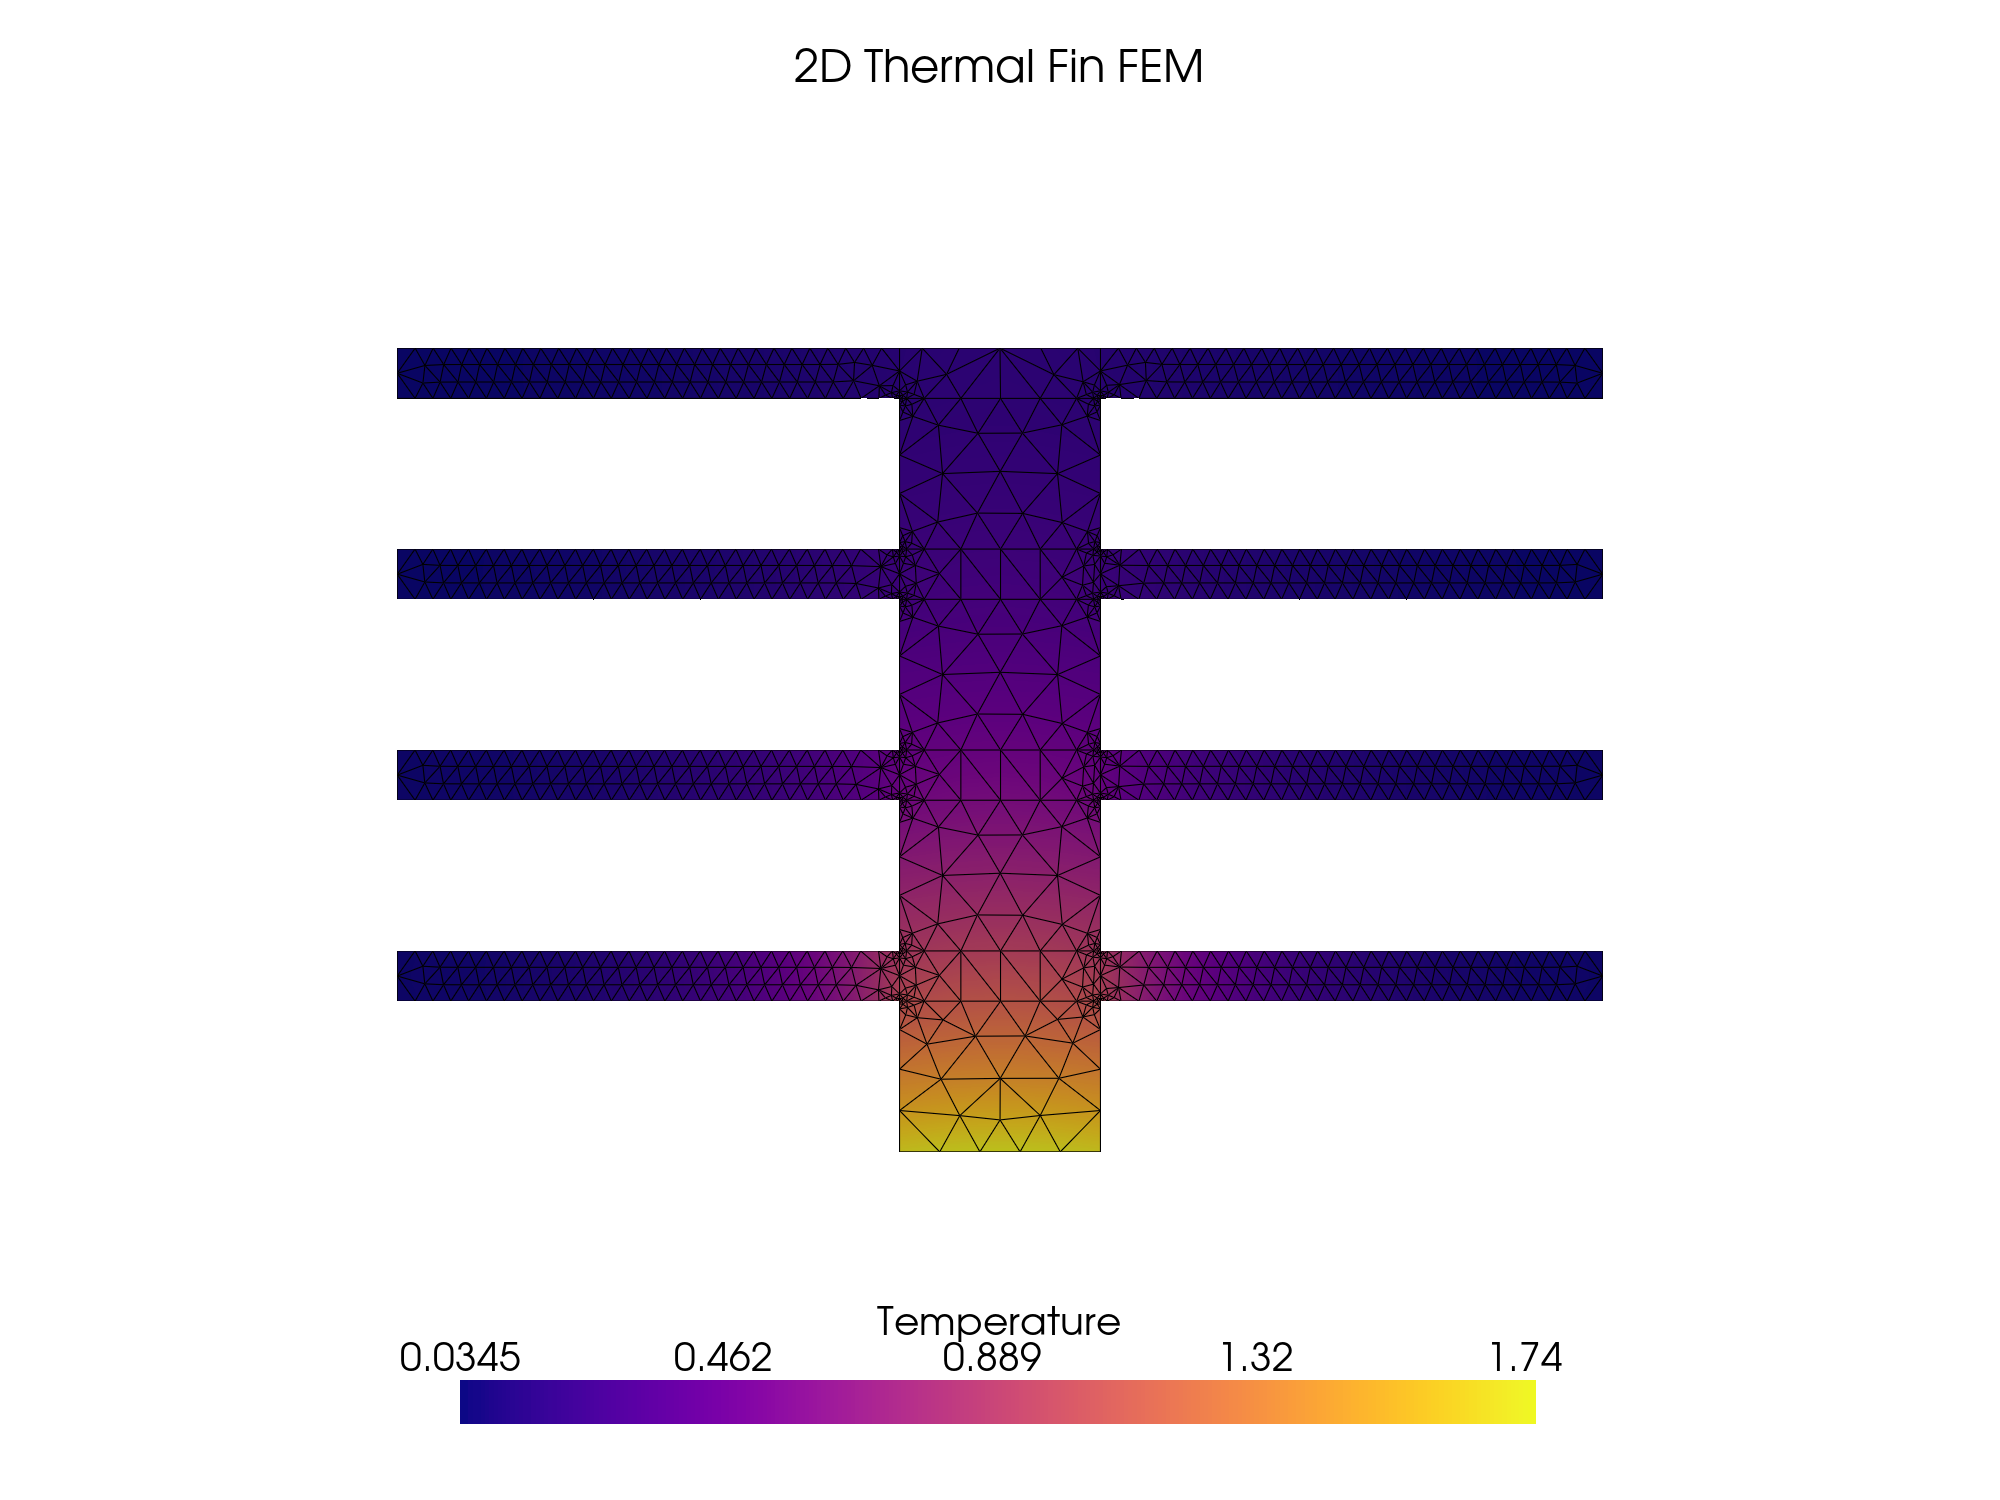

In [238]:
mu = [0.4, 0.6, 0.8, 1.2, 0.1]

Troot_coarse, u = thermal_fin(mesh, mu)
print('Troot =', Troot_coarse)
plot(mesh, u)

# # Example for running RB online
# rb_offline_data = load('rb_offline_data')
# ANq = rb_offline_data['ANq']
# FN = rb_offline_data['FN']

# mu1 = [0.4, 0.6, 0.8, 1.2, 0.1]
# mu2 = [1.8, 4.2, 5.7, 2.9, 0.3]

# uN, TrootN = reduced_basis_online(mu1, ANq, FN)

# print(TrootN)

### Medium mesh

In [239]:
# Example for computing FEM solution
mesh = medium_mesh

Troot = 1.7341628401775844


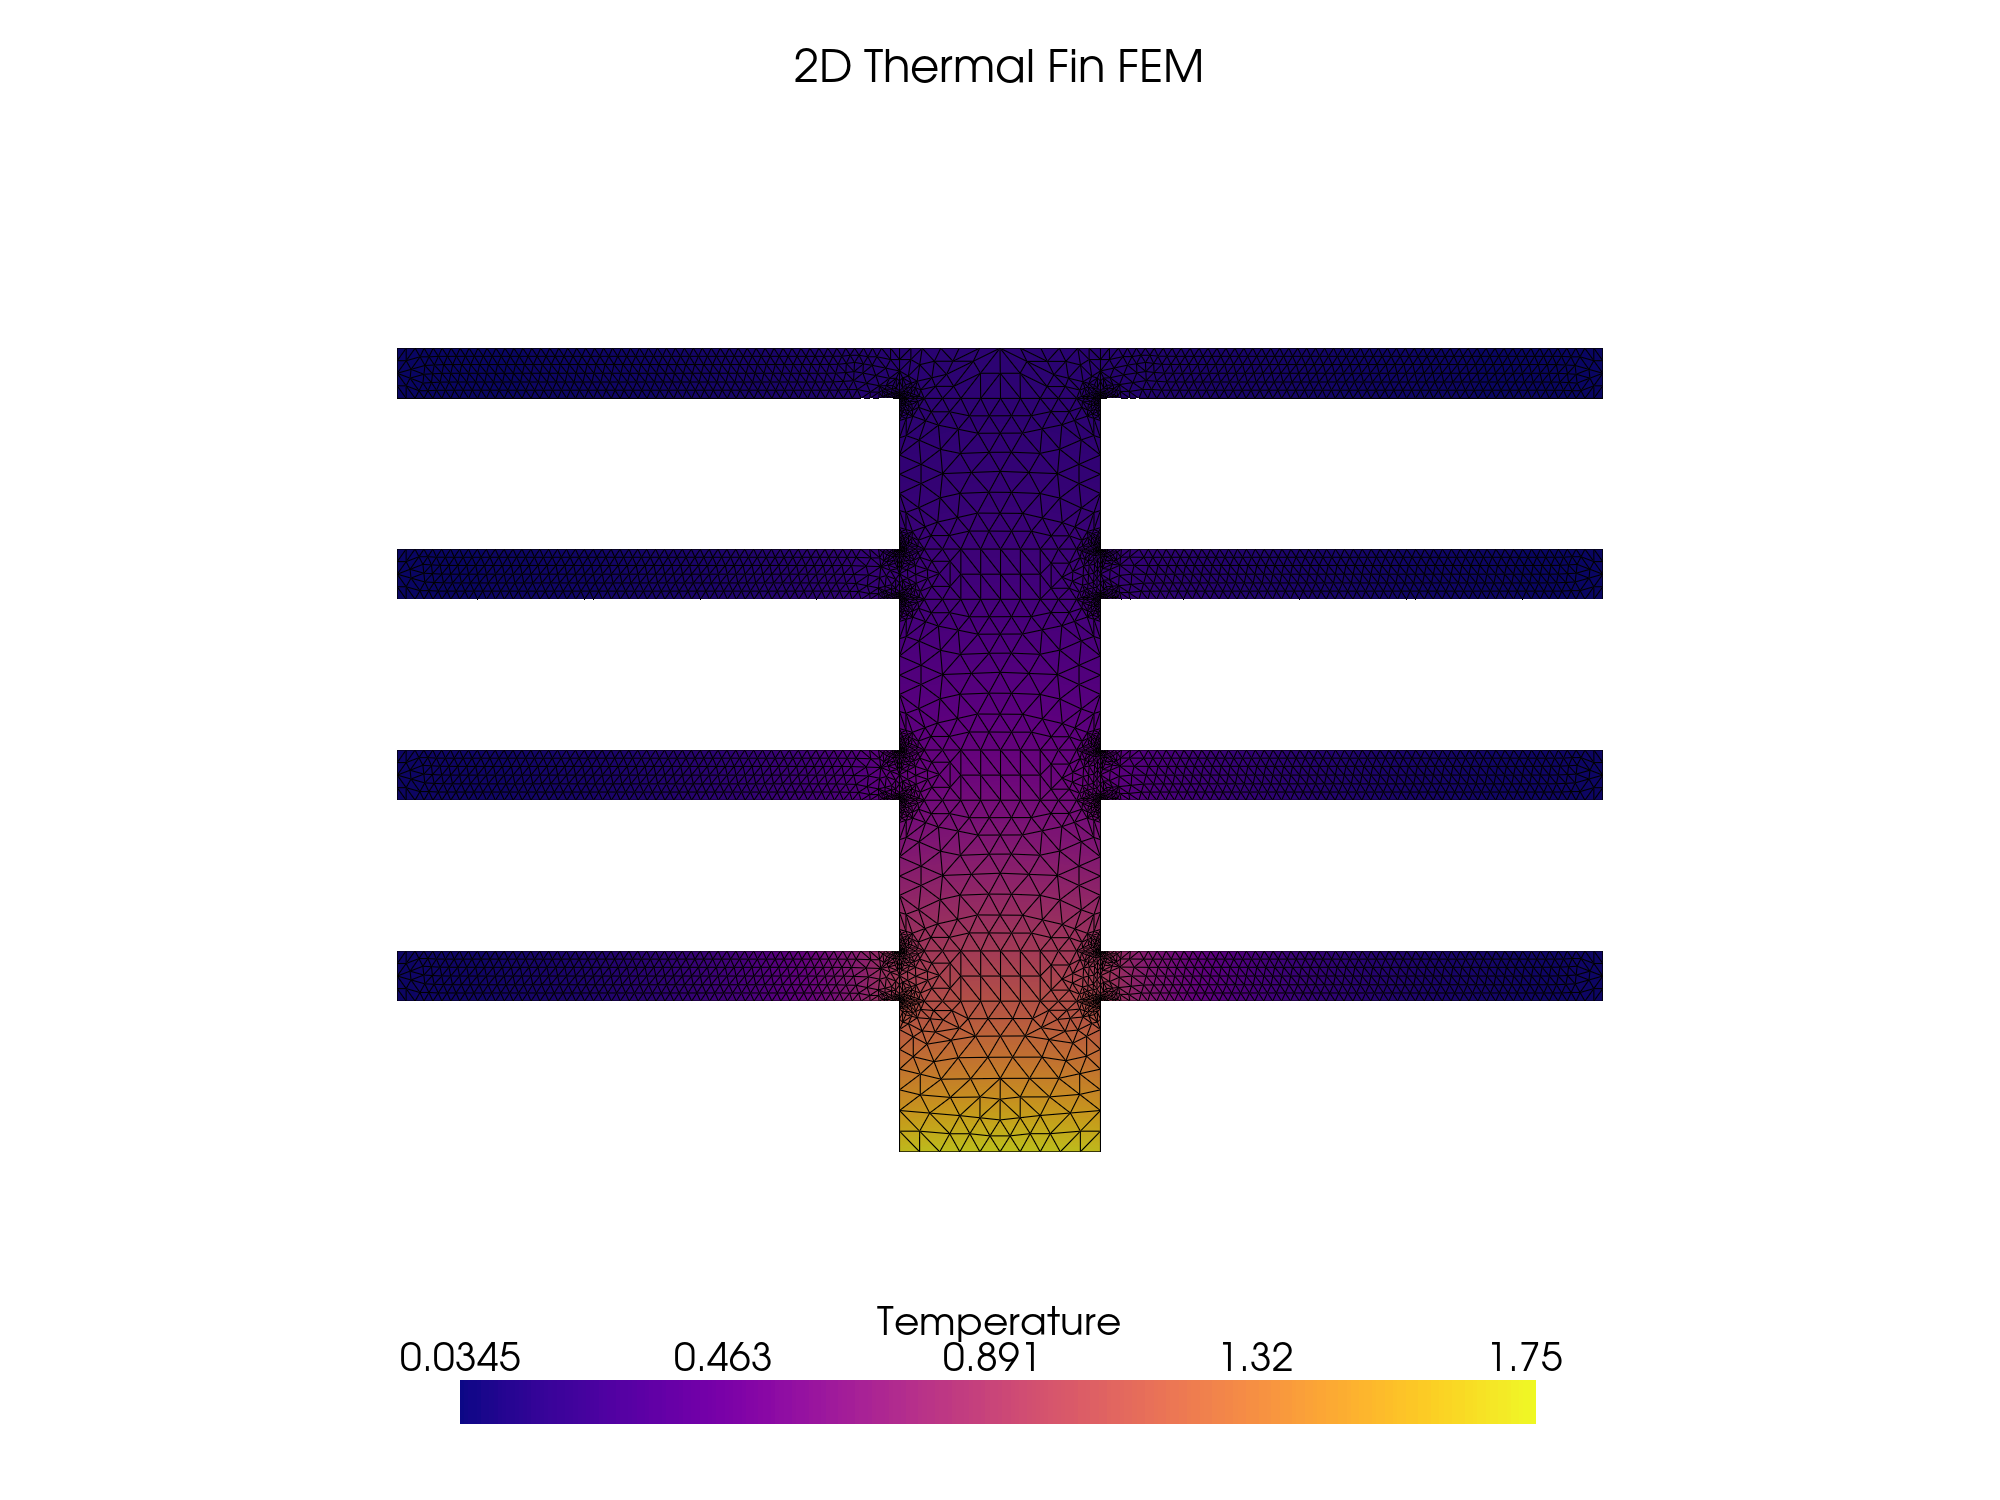

In [240]:
mu = [0.4, 0.6, 0.8, 1.2, 0.1]

Troot_medium, u = thermal_fin(mesh, mu)
print('Troot =', Troot_medium)
plot(mesh, u)

# # Example for running RB online
# rb_offline_data = load('rb_offline_data')
# ANq = rb_offline_data['ANq']
# FN = rb_offline_data['FN']

# mu1 = [0.4, 0.6, 0.8, 1.2, 0.1]
# mu2 = [1.8, 4.2, 5.7, 2.9, 0.3]

# uN, TrootN = reduced_basis_online(mu1, ANq, FN)

# print(TrootN)

### Fine mesh

In [241]:
# Example for computing FEM solution
mesh = fine_mesh

Troot = 1.7349763756513925


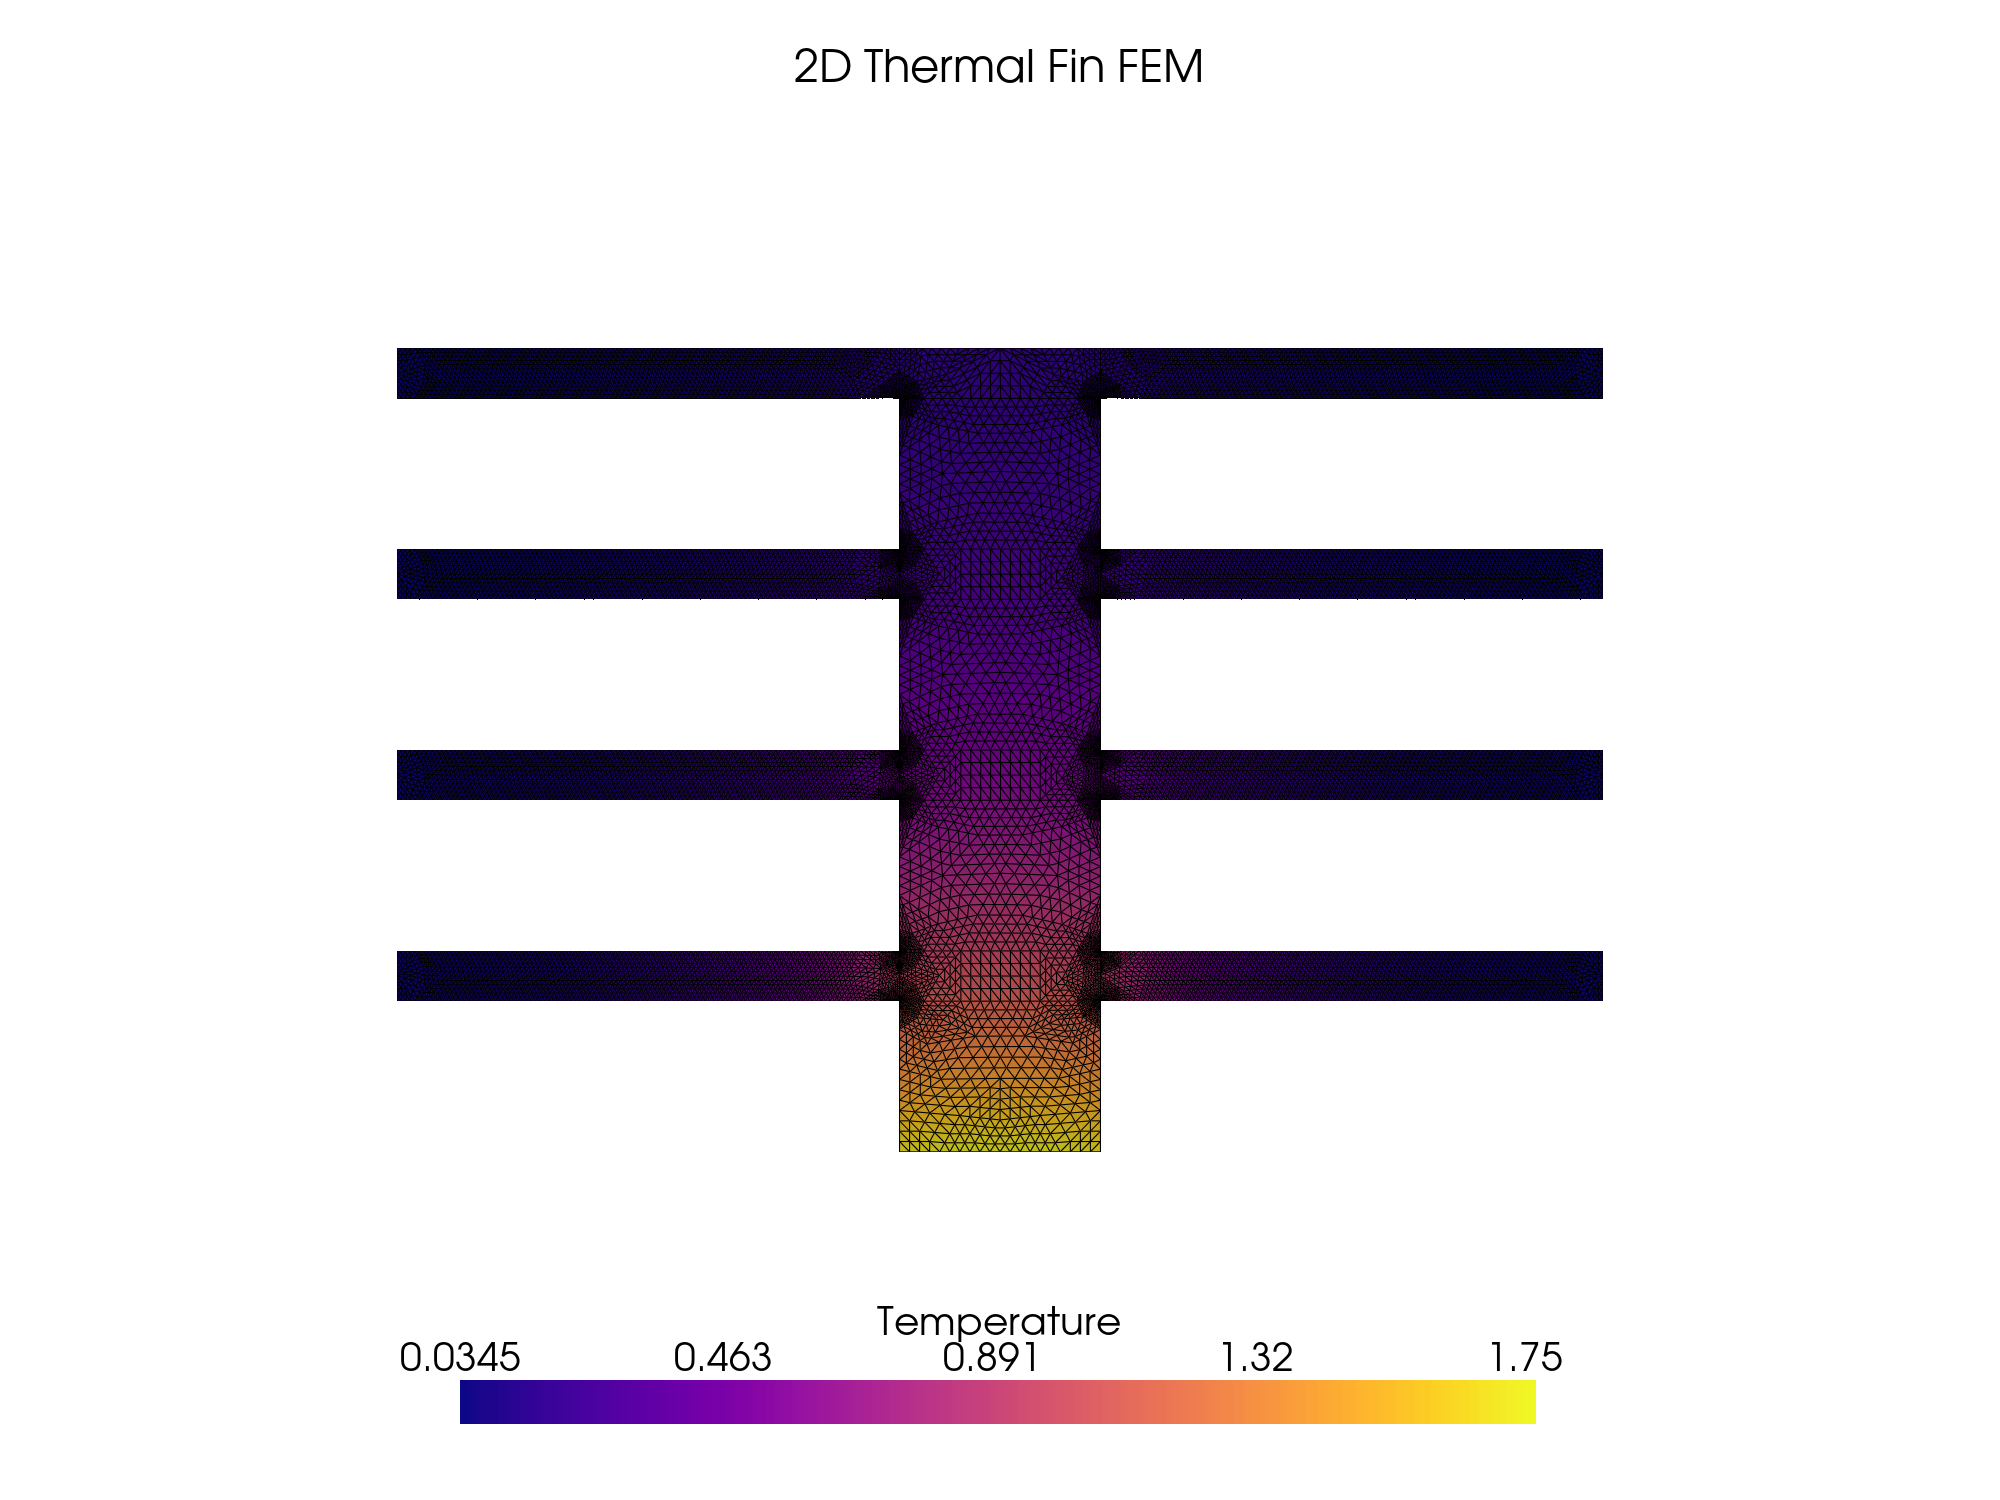

In [242]:
mu = [0.4, 0.6, 0.8, 1.2, 0.1]

Troot_fine, u = thermal_fin(mesh, mu)
print('Troot =', Troot_fine)
plot(mesh, u)

In [244]:
b = np.log((Troot_fine-Troot_coarse)/(Troot_fine-Troot_medium))/np.log(2)
print('b = {}'.format(round(b, 1)))

b = 2.2


## Part 2

In [6]:
from scipy.sparse import lil_matrix, csc_matrix

"""
 -------------------------------------------------------------------------

   ReducedBasisOffline.m

 -------------------------------------------------------------------------
   Reduced basis off-line: computes the reduced basis matrices and source
   vector from a sample.
 -------------------------------------------------------------------------
"""

# Load coarse mesh and sample data
mesh = coarse_mesh
sn = np.zeros([10, 5])
with open('sn.dat') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        sn_i = line.split()
        sn_i = [float(i) for i in sn_i]
        sn[i] =  sn_i

# Solve the sample cases and construct Z
N = sn.shape[0]
Z = np.zeros((coarse_mesh['nodes'], N))

# Construct Z - fill me in!

for i in range(N):
    mu = sn[i]
    Troot_fine, u = thermal_fin(mesh, mu)
    Z[:, i] = u

In [246]:
#print(Z)

In [7]:
# Initialization of reduced-base matrix and vector
F = lil_matrix((mesh['nodes'], 1))
ANq = []    # Using a list data structure to hold the six ANq matrices

# Calculate ANq and FN - fill me in!

# Domain Interior
for i in range(5):
    A = lil_matrix((mesh['nodes'], mesh['nodes']))
    for n in range(len(mesh['theta'][i])):
        phi = mesh['theta'][i][n,:]

        coord = np.concatenate([np.ones((mesh['coor'][phi].shape[0], 1)),mesh['coor'][phi]], axis=1)

        area_k = 0.5*np.linalg.det(coord)
        c = np.linalg.solve(coord, np.eye(mesh['coor'][phi].shape[0]))
        c = c[1:]
        cc = c.T@c
        A_local = cc*area_k
        A[phi[:, None], phi] += A_local
    ANq.append(A)

# Boundaries (not root)
i=5
A = lil_matrix((mesh['nodes'], mesh['nodes']))
for n in range(len(mesh['theta'][i])):
    phi = mesh['theta'][i][n,:]
    coord = mesh['coor'][phi]
    h_k = (((coord[0]-coord[1])**2).sum())**0.5
    A_local = h_k/6*np.array([[2, 1], [1, 2]])
    A[phi[:, None], phi] += A_local
ANq.append(A)
# Root boundary
i=6
for n in range(len(mesh['theta'][i])):
    phi = mesh['theta'][i][n,:]
    coord = mesh['coor'][phi]
    h_k = (((coord[0]-coord[1])**2).sum())**0.5
    F_local = 1/2*h_k*np.array([1, 1])
    F[phi] = F[phi] + F_local[:, None]
FN = F.T@Z


# Save the reduced matrix and vector
with shelve.open('rb_offline_data') as shelf:
    shelf['ANq'] = ANq
    shelf['FN'] = FN

In [8]:
def reduced_basis_online(mu, ANq, FN):
    """
    -------------------------------------------------------------------------

    ReducedBasisOnline.m

    -------------------------------------------------------------------------
    Reduced basis on-line: computes the temperature distribution and root
    temperature using the reduced basis computed by the off-line part.

    The reduced basis data ReducedBasis.mat should have been previously
    loaded using the comand "load ReducedBasis".
    -------------------------------------------------------------------------

    INPUT   mu      thermal conductivities of sections and Biot number 1x5
            N       dimension of the reduced basis
            ANq     reduced matrix
            FN      reduced source

    OUTPUT  uN      temperature discretization in the fin from reduced basis
            TrootN  root temperature from reduced basis

    -------------------------------------------------------------------------
    """

    # Parameter setup
    sigma = np.ones(6)
    sigma[:4] = mu[:4]
    sigma[5] = mu[4]       # Bi
    
    AN = np.zeros((Z.shape[1], Z.shape[1]))

    # Construct A_N from AN_qs
    for i in range(len(sigma)):

        AN += Z.T@(sigma[i]*ANq[i])@Z
        
    #print(FN[0])

    # Solve the system
    uN = np.linalg.solve(AN, FN.T)

    # Compute the temperature at the root
    TrootN = (FN@uN)[0]

    return uN, TrootN

In [9]:
# Example for running RB online
rb_offline_data = load('rb_offline_data')
ANq = rb_offline_data['ANq']
FN = rb_offline_data['FN']

mu1 = [0.4, 0.6, 0.8, 1.2, 0.1]
mu2 = [1.8, 4.2, 5.7, 2.9, 0.3]

uN, TrootN = reduced_basis_online(mu1, ANq, FN)

print('T_root (mu_0) = {}'.format(round(TrootN[0], 4)))

uN, TrootN = reduced_basis_online(mu2, ANq, FN)

print('T_root(mu_1) = {}'.format(round(TrootN[0], 4)))

T_root (mu_0) = 1.7262
T_root(mu_1) = 1.0748


In [10]:
k = np.array([0.4,0.6,0.8,1.2])
Bi_list = np.linspace(0.1, 10, 1000)
cost = []
for Bi in Bi_list:
    mu = np.concatenate((k, np.array([Bi])))
    uN, TrootN = reduced_basis_online(mu, ANq, FN)
    cost.append((0.2*Bi + TrootN)[0])

Text(0, 0.5, 'Cost')

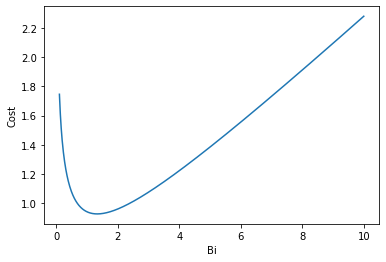

In [11]:
plt.plot(Bi_list, cost)
plt.xlabel('Bi')
plt.ylabel('Cost')

Optimal Bi =  1.3313983471772897 
Optimal cost =  0.9255128966182835


Text(0, 0.5, 'Cost')

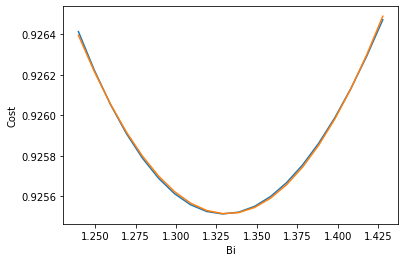

In [12]:
from scipy.optimize import curve_fit
def func(x, b, c, d):
    return(b*np.power(x, 2) + c*np.power(x, 1) + d)
st, en = 115, 135
p, c = curve_fit(func, Bi_list[st:en], np.array(cost[st:en]))
plt.plot(Bi_list[st:en], cost[st:en])
plt.plot(Bi_list[st:en], func(Bi_list[st:en], *p))
print('Optimal Bi = ', -p[1]/2/p[0], '\nOptimal cost = ', func(-p[1]/2/p[0], *p))
plt.xlabel('Bi')
plt.ylabel('Cost')